Taxi-3

Antonio Maulucci 2023

jupyter convert
https://stackoverflow.com/questions/15998491/how-to-convert-ipython-notebooks-to-pdf-and-html

Librerie

In [4]:
import os
!git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
os.chdir('PyGame-Learning-Environment')
!pip install -e .
!pip install pygame
os.chdir('/content')

Cloning into 'PyGame-Learning-Environment'...
remote: Enumerating objects: 1118, done.
remote: Total 1118 (delta 0), reused 0 (delta 0), pack-reused 1118
Receiving objects: 100% (1118/1118), 8.06 MiB | 32.86 MiB/s, done.
Resolving deltas: 100% (592/592), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/PyGame-Learning-Environment
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ple
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 54.7 MB/s eta 0:00:00


In [5]:
#https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

In [171]:
import gym # ambiente
from time import sleep # per la stampa
import numpy as np # per la Q-table
import random
from tqdm import tqdm # progressbar

funzione per visualizzare l'ambiente tramite Colab

In [22]:
def _render(env):
    clear_output(wait=True)
    plt.imshow( env.render(mode='rgb_array') )
    plt.show()



---


Creazione dell'ambiente

In [13]:
env = gym.make('Taxi-v3') # ambiente taxi gia' forito da openai

ambiente

In [14]:
state = env.reset() # reset dell'ambiente ad un nuovo stato, random

render dell'ambiente

In [15]:
# env.render()

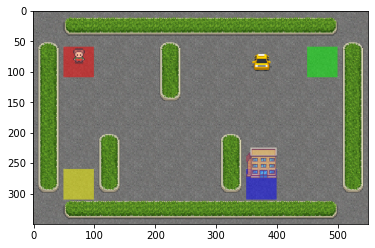

In [16]:
clear_output(wait=True)
plt.imshow( env.render(mode='rgb_array') )
plt.show()

In [17]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


In [27]:
state=env.encode(3,1,2,0) # (riga del taxi, colonna del taxi, indice del passeggero, indice della destinazione)
print("state: ", state)

state:  328


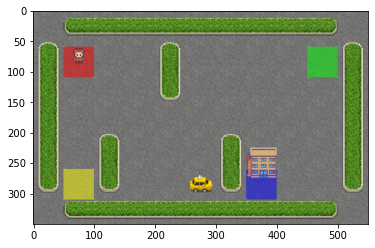

In [99]:
env.s = state
_render(env)

mostrare la reward table

dove 328 è il valore di state

e il dizionario ha la struttura {azione: [(probabilità, stato successivo, reward, eseguito)]}

in questo ambiente la probabilità è sempre 1.0

lo stato successivo è lo stato in cui vogliamo trovarci dopo aver eseguito l'azione

inizialmente tutte le azioni hanno reward -1 eccetto pickup/dropoff che hanno -10

eseguito (done) indica se è stato lasciato il passeggero nella giusta destinazione

In [98]:
print(env.P[328])

{0: [(1.0, 428, -1, False)], 1: [(1.0, 228, -1, False)], 2: [(1.0, 348, -1, False)], 3: [(1.0, 328, -1, False)], 4: [(1.0, 328, -10, False)], 5: [(1.0, 328, -10, False)]}




---


# **Soluzione senza reinforcement learning**

🚩

In [89]:
env.s = 328 # impostare lo stato dell'ambiente

In [90]:
epochs = 0
reward,penals = 0,0

In [91]:
frames = [] # per le animazioni

In [92]:
done = False # flag per il termine dell'esecuzione

esecuzione

In [93]:
while not done:
    action = env.action_space.sample() # ottengo una qualsiasi azione dall'action space
    state, reward, done, info = env.step(action) # eseguo l'azione
    
    if reward == -10:
        penals += 1
    
    # memorizzo i vari step per la stampa finale
    frames.append(
        {'frame' : env.render(mode='ansi'),
         'state' : state,
         'action' : action,
         'reward' : reward}
    )

    epochs +=1

In [108]:
print("Time Steps: {}".format(epochs))
print("Penalties: {}".format(penals))

Time Steps: 44
Penalties: 18


esecuzione con stampa 🚩

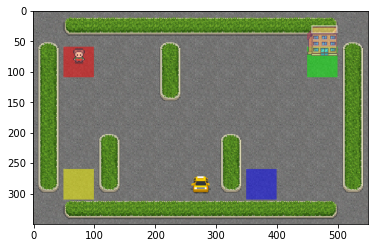

In [126]:
state = env.reset() # reset dell'ambiente ad un nuovo stato, random
_render(env)

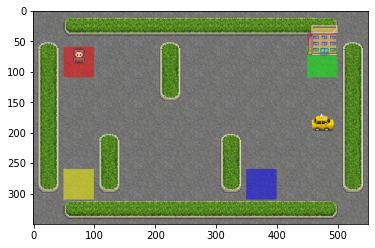

step 199, action 2, state 281, rewards -1, pen 66


In [127]:
epochs = 0
reward,penals = 0,0
done = False # flag per il termine dell'esecuzione
while not done:
    action = env.action_space.sample() # ottengo una qualsiasi azione dall'action space
    state, reward, done, info = env.step(action) # eseguo l'azione
    
    if reward == -10:
        penals += 1
    
    _render(env)
    print("step {}, action {}, state {}, rewards {}, pen {}".format(epochs, action, state, reward, penals))

    epochs +=1

In [128]:
print("Time Steps:{}".format(epochs))
print("Penalties: {}".format(penals))

Time Steps:200
Penalties: 66


Un valore così alto di penalties è dovuto al fatto che l'autista non impara nulla dalle esperienze pregresse e inoltre impiega un tempo eccessivo per portare un singolo passeggero a destinazione

# da qui si fa sul serio 🔥

In [183]:
num_exec = 150000
num_exec_ii = 1500

# **Implementazione senza reinforcement learning ma con misurazione delle statistiche**

In [178]:
total_pens = 0
total_eps = 0

In [184]:
for i in tqdm(range(0, num_exec_ii), desc="Loading..."): # progressbar
    state = env.reset() # reset dell'ambiente ad un nuovo stato, random
    epochs = 0
    reward,penals = 0,0
    done = False # flag per il termine dell'esecuzione
    while not done:
        action = env.action_space.sample() # ottengo una qualsiasi azione dall'action space
        state, reward, done, info = env.step(action) # eseguo l'azione
        
        if reward == -10:
            penals += 1

        epochs +=1
    
    total_pens += penals
    total_eps += epochs

Loading...: 100%|██████████| 1500/1500 [00:12<00:00, 117.57it/s]




---


# **Implementazione con reinforcement learning**

Nel reinforcement learning l'agente impara dalla tabella P dei rewards aggiornando il Q-Value per imparare se l'azione compiuta è stata corretta o meno.

## Q-Value

Il Q-Value è una "mappa" stato-azione e "misura" la qualità di un'azione intrapresa. Inizialmente il ***Q-Value*** viene inzializzato ad un valore arbitrario; successivamente viene calcolato come

$Q(\text{state, action}) = \left( 1 - \alpha \right) Q(\text{state, action}) + \alpha  \left(  \text{reward} + \gamma \underset{a}{max} Q \left( \text{next state, all actions} \right)  \right)$

dove

$\alpha \left( 0 < \alpha \le 1 \right)$ è il learning rate ovvero la misura in cui il Q-Value viene aggiornato in ogni iterazione

$\gamma \left( 0 \le \gamma \le 1 \right)$ è il discount factor e determina l'importanza che vogliamo attribuire ai reward futuri; 1 indica una massima attenzione ai reward futuri mentre 0 indica una massima attenzione al rewrd immediato

## Q-Table

E' una matrice che ha una riga per ogni stato possibile (in questo caso 500) e una colonna per ogni possibile azione (6).
Inizialmente è inizializzata a 0 e poi viene aggiornata dopo il trining. Ha la stessa dimensione della reward table.

## Processo di Q-Learning

1. inizializzare la Q-Table a 0
2.   Avviare le operazioni di "esplorazione"
3. transitare in un nuovo stato in seguito ad un'azione
4. per tutti i possibili stati scegliere quello con il Q-Value più alto
5. aggiornare la tabella mediante l'equazione illustrata
6. impostare lo stato successivo come stato corrente
7. se l'obiettivo è stato raggiunto, terminare e ripetere il processo





inizializzare la q-table 🚩

In [133]:
q_table = np.zeros([env.observation_space.n, env.action_space.n    ])

parametri di learning

In [135]:
alpha = 0.1
gamma = 0.6
epsilon = 0.1

variabili per la stampa delle statistiche

In [156]:
all_epochs = []
all_penalties = []
total_penalties = 0
total_epochs = 0

esecuzione ⚡

In [172]:
# for i in range(0, num_exec):
for i in tqdm(range(0, num_exec), desc="Loading..."): # progressbar
    state = env.reset() # reset dell'ambiente ad un nuovo stato, random
    # _render(env)
    epochs = 0
    reward,penalties = 0,0
    done = False # flag per il termine dell'esecuzione

    while not done:
        if random.uniform(0,1) < epsilon:
            action = env.action_space.sample() # esplora l'ambiente
        else:
            action = np.argmax(q_table[state]) #exploit
        
        next_state, reward, done, info = env.step(action) # eseguo l'azione

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1-alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
        
        state = next_state
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

    # if i % 100 == 0:
    #     _render(env)
    #     print("step {} of {}, action {}, state {}, rewards {}, pen {}".format(i, num_exec, action, state, reward, penals))


Loading...: 100%|██████████| 150000/150000 [01:45<00:00, 1424.54it/s]


In [173]:
print(q_table[328])

[ -2.41816813  -2.27325184  -2.41832065  -2.36390838 -11.35912443
 -11.36031445]


# statistiche

senza q-learning

In [186]:
print("dopo {} step: average_time= {}, average_pens= {} ".format(num_exec_ii, total_eps/num_exec_ii, total_pens/num_exec_ii))

dopo 1500 step: average_time= 513.8733333333333, average_pens= 167.14933333333335 


con q-learning

In [174]:
print("dopo {} step: average_time= {}, average_pens= {} ".format(num_exec, total_epochs/num_exec, total_penalties/num_exec))

dopo 150000 step: average_time= 24.214106666666666, average_pens= 0.7154533333333334 


# Termine dell'esecuzione

In [187]:
env.close()